# サマリ(仮データ)
# データ
- 90フォルダl_goalのみ, 左右入れ替えあり
- 訓練データ
- テストデータ

# モデル
双方向LSTMでモデルを構築
- 入力層は(batch_size, 20, 49)
- 中間層は64次元
- 出力層は(batch_size, 30, 49)
- LSTMの層数は2
- 200epoch
- batch_size=1024

# 結果
- ファイル: models/model_20250213080825.pth
- val_loss: 5.0996 (200epochでまだ下がりそう)
- 最終ユークリッド誤差: 38.876747
- 訓練時間: 20分

In [1]:
import pandas as pd
import torch
import datasets
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import numpy as np
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import visualizer

In [2]:
dataset = datasets.load_dataset(
    "ReonOhashi/RobocupTrajectoryPrediction_8team",
    revision="ab9aaf0feeb14402e112fb1bd94d26dd5d0ba507",
)
dataset = dataset["train"]
train_raw, test_raw = dataset.train_test_split(test_size=0.2, seed=42).values()

README.md:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

train-00000-of-00010.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

train-00001-of-00010.parquet:   0%|          | 0.00/390M [00:00<?, ?B/s]

train-00002-of-00010.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

train-00003-of-00010.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

train-00004-of-00010.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

train-00005-of-00010.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

train-00006-of-00010.parquet:   0%|          | 0.00/386M [00:00<?, ?B/s]

train-00007-of-00010.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

train-00008-of-00010.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

train-00009-of-00010.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/237599 [00:00<?, ? examples/s]

In [3]:
len(train_raw), len(test_raw)

(190079, 47520)

In [4]:
from typing import Union


def swap_rl(df):
    # swap data between left and right
    df["l_name"], df["r_name"] = df["r_name"], df["l_name"]
    df["b_x"] *= -1

    for i in range(1, 12):
        l_x, r_x = f"l{i}_x", f"r{i}_x"
        l_y, r_y = f"l{i}_y", f"r{i}_y"

        df[l_x], df[r_x] = -df[r_x].values, -df[l_x].values
        df[l_y], df[r_y] = df[r_y].values, df[l_y].values

    return df


def to_np(df: Union[datasets.arrow_dataset.Dataset, list[pd.DataFrame]]) -> np.ndarray:
    if isinstance(df, datasets.arrow_dataset.Dataset):
        a = []
        for data in tqdm(df):
            df_data = pd.DataFrame(data)
            goal_type = df_data["goal_type"].iloc[0]
            df_data = df_data.drop(columns=["goal_type"]).values
            if goal_type == "goal_l" or goal_type is None:
                a.append(df_data)
            elif goal_type == "goal_r":
                a.append(swap_rl(pd.DataFrame(data)).drop(columns=["goal_type"]).values)
            else:
                raise ValueError
        return np.stack(a)
    elif isinstance(df, list):
        return np.stack([data.drop(columns=["goal_type"]).values for data in df])


def to_df(arrs):
    feature_columns = dataset.column_names
    columns = [col for col in feature_columns if col != "goal_type"]
    return [pd.DataFrame(arr, columns=columns).assign(goal_type=None) for arr in arrs]


train, test = to_np(train_raw), to_np(test_raw)
print(train.shape, test.shape)

  0%|          | 0/190079 [00:00<?, ?it/s]

  0%|          | 0/47520 [00:00<?, ?it/s]

(190079, 50, 49) (47520, 50, 49)


In [5]:
# remove nan and inf
print(train.shape, test.shape)  # (5708, 50, 49) (1424, 50, 49)

train = train[~np.isnan(train).any(axis=(1, 2))]
test = test[~np.isnan(test).any(axis=(1, 2))]

print(train.shape, test.shape)

(190079, 50, 49) (47520, 50, 49)
(189860, 50, 49) (47465, 50, 49)


In [6]:
X_train, y_train = train[:, :20, :], train[:, 20:, :]
X_test, y_test = test[:, :20, :], test[:, 20:, :]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(189860, 20, 49) (189860, 30, 49) (47465, 20, 49) (47465, 30, 49)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# TensorDataset と DataLoader の作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 1024
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16
)
val_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16
)

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint


class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        else:
            self.train_losses.append(None)

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
        else:
            self.val_losses.append(None)


class LitBiLSTM(pl.LightningModule):
    def __init__(
        self, input_dim, hidden_dim, output_dim, num_layers, seq_length, lr=0.001
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim * seq_length)
        self.criterion = nn.MSELoss()
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        output = self.fc(last_out)
        return output.view(-1, 30, self.hparams.output_dim)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


# チェックポイントのコールバックを定義（val_lossが改善したときに保存）
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="bilstm-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    mode="min",
)

# 損失の履歴を保存するコールバックを定義
loss_history = LossHistory()

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, loss_history],
)


X_train.shape  # b, 20, 49
y_train.shape  # b, 30, 49

# # X_train の shape が (サンプル数, timesteps, features) であることを前提
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = y_train.shape[2]
seq_length = y_train.shape[1]
num_layers = 2

model = LitBiLSTM(input_dim, hidden_dim, output_dim, num_layers, seq_length, lr=0.001)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /root/robocup/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 158 K  | train
1 | fc        | Linear  | 189 K  | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.391     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


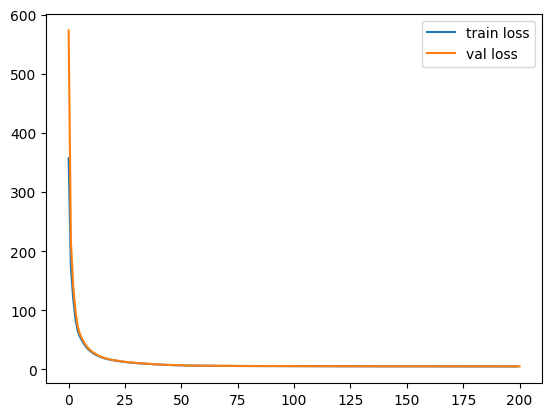

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_history.train_losses, label="train loss")
plt.plot(loss_history.val_losses, label="val loss")

plt.legend()

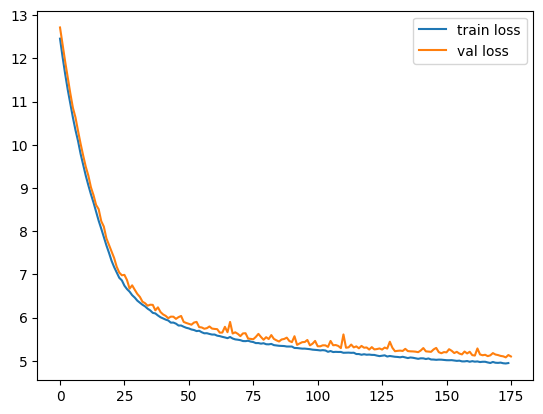

In [13]:
# loss の推移を確認

import matplotlib.pyplot as plt

plt.plot(loss_history.train_losses[25:], label="train loss")
plt.plot(loss_history.val_losses[25:], label="val loss")

plt.legend()

In [18]:
def check_test(test):
    index = 0
    X_test, y_test = test[index, :20, :], test[index, 20:, :]
    # display(X_test.shape, y_test.shape)  # (20, 49) (30, 49)
    X_test = np.array([X_test])
    # display(X_test.shape)  # (1, 20, 49)

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    model.to(device)

    with torch.no_grad():
        pred = model.forward(X_test)

    # display(pred.shape)  # (1, 30, 49)
    # display(y_test.shape)  # (30, 49)

    pred = pred[0]
    X_test = X_test[0]

    # display(X_test.shape)  # (20, 49)
    # display(pred.shape)  # (30, 49)
    # display(y_test.shape)  # (30, 49)

    X_test = X_test.cpu().numpy()
    pred = pred.cpu().numpy()
    y_test = y_test.cpu().numpy()

    pred = np.concatenate([X_test, pred], axis=0)
    y_test = np.concatenate([X_test, y_test], axis=0)

    # display(pred.shape)  # (50, 49)
    # display(y_test.shape)  # (50, 49)

    display(visualizer.visualizer_np2(y_test, pred))


check_test(train)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
import math


def check_test_batch(test):
    X_test, y_test = test[:, :20, :], test[:, 20:, :]
    # display(X_test.shape, y_test.shape)  # (b, 20, 49) (b, 30, 49)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model.to(device)
    with torch.no_grad():
        pred = model.forward(X_test)

    # display(pred.shape)  # (b, 30, 49)

    # ここでは各サンプルの最後の予測のみを用いて誤差を計算する
    pred = pred[:, -1, :].cpu().numpy()
    y_true = y_test[:, -1, :].cpu().numpy()
    # display(pred.shape, y_true.shape)  # (b, 49) (b, 49)

    # 誤差計算：features のうち、インデックス 2 と 3、4 と 5、…、24 と 25 の組ごとに
    # ユークリッド距離を計算して各サンプルごとに合計し、バッチ全体の平均をとる
    indices = np.arange(2, 26, 2)  # [2, 4, 6, ..., 24]
    errors = np.sqrt(
        (pred[:, indices] - y_true[:, indices]) ** 2
        + (pred[:, indices + 1] - y_true[:, indices + 1]) ** 2
    )

    # display(errors.shape)  # (b, 12)
    # 各サンプルごとに距離の合計、さらに全サンプルで平均
    result = np.mean(np.sum(errors, axis=1))
    return result


batched_test = [test[i : i + 1024] for i in range(0, len(test), 1024)]

errors = sum([check_test_batch(test) for test in tqdm(batched_test)]) / len(
    batched_test
)

print(errors)

  0%|          | 0/47 [00:00<?, ?it/s]

38.876747


In [16]:
import time

model_name = f"model_{time.strftime('%Y%m%d%H%M%S')}.pth"
# save model
torch.save(model.state_dict(), f"models/{model_name}")

# load model
model = LitBiLSTM(input_dim, hidden_dim, output_dim, num_layers, seq_length, lr=0.001)
model.load_state_dict(torch.load(f"models/{model_name}"))
print(model_name)

model_20250213080825.pth


# サマリ
